# Swin Transformer Explained with a Pytorch implementation
> Learn about the building blocs of the SWin Transformer model for image classification and how to implement it in TensorFlow

- toc: false
- badges: true
- comments: true
- author: dzlab
- categories: [tensorflow, vision, classification]f

After the introduction of the [ViT architecture](https://dzlab.github.io/notebooks/tensorflow/vision/classification/2021/10/01/vision_transformer.html) for image classification, many similar works attempted to use a Transormer based architecture for building a classification mode. One of the top performer is proposed in the paper [Swin Transformer: Hierarchical Vision Transformer using Shifted Windows](https://arxiv.org/pdf/2103.14030.pdf). This paper come with the following import contributions:
- Building a hierarchical representation of the input image by taking patches of small sizes and gradually increasing their size.
- Instead of applying Transformer's attention to the entire input as usually done in NLP tasks, attention is calculated locally from non-overlapping shifted windows.
- Comprehensive experiments on various vision tasks and model architectures and strong results, e.g. 58.7 box AP and 51.1 mask AP on test-dev on COCO object detection.

In [22]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision import transforms
from torchvision.transforms import Resize
from torchvision.io import read_image
import matplotlib.pyplot as plt

In [49]:
class PatchPartition(nn.Module):
    def __init__(self, window_size=4, channels=3):
        super(PatchPartition, self).__init__()
        self.window_size = window_size
        self.channels = channels

    def forward(self, images):
        # PyTorch中unfold方法的使用需要先确定图像数据的维度格式为[B, C, H, W]
        assert images.dim() == 4, "Input must have 4 dimensions [B, C, H, W]"
        
        # 使用unfold方法提取patches
        # 结果的形状将是[B, C, H', W', window_size, window_size]
        patches = images.unfold(2, self.window_size, self.window_size).unfold(3, self.window_size, self.window_size)
        
        # 调整patches的形状以合并窗口大小维度，形成[B, C*window_size*window_size, H'*W']
        batch_size, channels, H_prime, W_prime, _, _ = patches.size()
        patches = patches.contiguous().view(batch_size, channels, H_prime*W_prime, -1).permute(0, 2, 1, 3)
        
        # 最终形状为[B, H'*W', C*window_size*window_size]，合并了通道和窗口大小维度
        patches = patches.reshape(batch_size, -1, channels * self.window_size * self.window_size)
        
        return patches

# 测试PatchPartition层
if __name__ == "__main__":
    # 创建一个随机的图像批量[B, C, H, W]
    images = torch.randn(1, 3, 224, 224)
    
    # 实例化PatchPartition层
    patch_partition = PatchPartition(window_size=4, channels=3)
    
    # 前向传播
    patches = patch_partition(images)
    
    print("Patches shape:", patches.shape)


def torch_extract_patches(
    x, patch_height, patch_width, padding=None
):
    x = x.unsqueeze(0)
    #if padding == "SAME":
    #    x = F.pad(x, (1, 1, 1, 1))
    patches = F.unfold(x, (patch_height, patch_width), stride=(patch_height, patch_width))
    patches = patches.reshape(x.size(0), x.size(1), patch_height, patch_width, -1)
    patches = patches.permute(0, 4, 2, 3, 1).reshape(x.size(2)//patch_height, x.size(3)//patch_width, x.size(1)*patch_height*patch_width)
    return patches




Patches shape: torch.Size([1, 3136, 48])


image shape is:  (224, 224, 3)


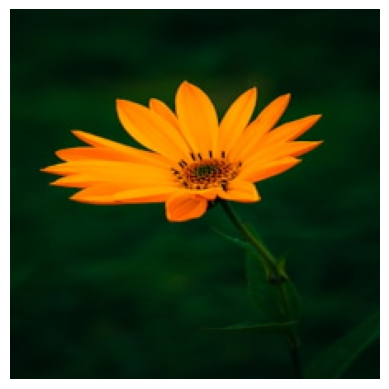

In [48]:
# 读取图像
image = read_image('flower.jpeg')  # 读取图像，返回的是[C, H, W]格式的Tensor

# 创建一个transform来调整图像大小
transform = transforms.Compose([
    transforms.Resize((224, 224))  # 调整图像大小到224x224
])

# 应用transform
image = transform(image)

# 将图像的数据类型从torch.Tensor转换为numpy array，并调整维度顺序为[H, W, C]用于显示
image = image.permute(1, 2, 0).numpy()
print("image shape is: ", image.shape)
# 使用matplotlib显示图像
plt.imshow(image.astype('uint8'))
plt.axis('off')  # 不显示坐标轴
plt.show()


In [64]:
batch = torch.unsqueeze(torch.tensor(image), 0)
input_data = batch.permute(0, 3, 1, 2)
print(batch.shape, input_data.shape)

torch.Size([1, 224, 224, 3]) torch.Size([1, 3, 224, 224])


In [50]:
patches = PatchPartition()
patches_data = patches(input_data)
print(patches_data.shape)  # torch.Size([196, 4, 4, 48])

torch.Size([1, 3136, 48])


验证第一个patchs_data的值

In [27]:
patches_data[0,0,:]  # 第一个patch的第一个像素的所有通道的值

tensor([ 0,  0,  0,  1,  0,  0,  0,  1,  0,  0,  0,  1,  0,  0,  0,  1, 20, 20,
        20, 21, 20, 20, 20, 21, 20, 20, 20, 21, 20, 20, 20, 21,  8,  8,  8,  9,
         8,  8,  8,  9,  8,  8,  8,  9,  8,  8,  8,  9], dtype=torch.uint8)

Now we can examine the partitions that we just created

In [173]:
n = int(np.sqrt(patches_data.shape[1]))
print(f"there is a total of {n} x {n} patches")
plt.figure(figsize=(10, 10))    
for i, patch in enumerate(patches_data[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = patch.view(3, 4, 4)
    patch_img = patch_img.permute(1, 2, 0)
    ax.imshow(patch_img.numpy().astype("uint8"))
    ax.axis("off")

there is a total of 56 x 56 patches


In [86]:
import torch
import torch.nn as nn

class PatchPartition_torch_1(nn.Module):
    def __init__(self, window_size=4, channels=3):
        super(PatchPartition_torch_1, self).__init__()
        self.window_size = window_size
        self.channels = channels

    def forward(self, images):
        # 验证输入images的形状为[B, C, H, W]
        assert images.dim() == 4, "Input must have 4 dimensions [B, C, H, W]"
        
        # 使用unfold方法在高度H和宽度W上提取大小为window_size的patches
        # 得到的patches形状为[B, C, H', W', window_size, window_size]
        patches = images.unfold(2, self.window_size, self.window_size).unfold(3, self.window_size, self.window_size)
        
        # 调整patches的形状为[B, H'*W', C*window_size*window_size]
        # 这里H'和W'分别是沿高度和宽度方向上的patches数量
        batch_size, c, h_unfold, w_unfold, _, _ = patches.size()
        patches = patches.permute(0, 2, 3, 1, 4, 5).contiguous()
        patches = patches.view(batch_size, -1, c * self.window_size ** 2)
        
        return patches

# 测试PatchPartition模块
if __name__ == "__main__":
    # 创建一个随机输入tensor模拟图像批量，形状为[B, C, H, W]
    input_tensor = torch.randn(1, 3, 224, 224)
    
    # 实例化PatchPartition并应用于输入tensor
    patch_partition = PatchPartition_torch_1(window_size=4, channels=3)
    patches = patch_partition(input_tensor)
    
    print("Output patches shape:", patches.shape)
    # 预期输出形状为 [1, num_patches, patch_dim]
    # 其中num_patches为图像在window_size=4的设置下沿高度和宽度方向上的patch总数
    # patch_dim为每个patch的维度，这里是window_size*window_size*channels


Output patches shape: torch.Size([1, 3136, 48])


In [68]:
patches = PatchPartition()
patches_data = patches(input_data)
print(patches_data.shape)  # torch.Size([196, 4, 4, 48])

torch.Size([1, 3136, 48])


In [70]:
patches_data[0, 0, :]  # 第一个patch的第一个像素的所有通道的值

tensor([ 0,  0,  0,  1,  0,  0,  0,  1,  0,  0,  0,  1,  0,  0,  0,  1, 20, 20,
        20, 21, 20, 20, 20, 21, 20, 20, 20, 21, 20, 20, 20, 21,  8,  8,  8,  9,
         8,  8,  8,  9,  8,  8,  8,  9,  8,  8,  8,  9], dtype=torch.uint8)

In [141]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import (
    Add, Dense, Dropout, Embedding, GlobalAveragePooling1D, Input, Layer, LayerNormalization, MultiHeadAttention,
    Softmax
)
from tensorflow.keras.initializers import TruncatedNormal

def pad_if_necessary(
    inputs: torch.Tensor,
    window_size: int,
) -> torch.Tensor:
    if inputs.size(-1) % window_size != 0 or inputs.size(-2) % window_size != 0:
        h = (inputs.size(-2) + window_size - 1) // window_size * window_size
        w = (inputs.size(-1) + window_size - 1) // window_size * window_size
        padded = torch.zeros((inputs.size(0), inputs.size(1), h, w), dtype=inputs.dtype, device=inputs.device)
        padded[..., :inputs.size(-2), :inputs.size(-1)] = inputs
        inputs = padded
    return inputs


class PatchPartition_torch(nn.Module):
    """
    Implements the Patch Partition module from Swin-Transformers
    """
    def __init__(
        self,
        patch_size: int = 4
    ):
        super(PatchPartition_torch, self).__init__()
        self.patch_size = patch_size
    
    def forward(
        self,
        images: torch.Tensor
    ) -> torch.Tensor:
        images = pad_if_necessary(images, self.patch_size)
        patches = images.reshape(images.size(0), images.size(1),
                                 images.size(2) // self.patch_size, self.patch_size,
                                 images.size(3) // self.patch_size, self.patch_size)  # break into windows
        features = patches.permute(0, 1, 3, 5, 2, 4).flatten(start_dim=1, end_dim=3)  # flatten patches
        features = features.view(features.size(0), features.size(1), -1).permute(0, 2, 1)  # flatten windows
        return features


class PatchPartition(Layer):
    def __init__(self, window_size=4, channles=3):
        super(PatchPartition, self).__init__()
        self.window_size = window_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.window_size, self.window_size, 1],
            strides=[1, self.window_size, self.window_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )

        patch_dims = patches.shape[-1]
        # 每个pathch size个kernel ，然后通道channel方向进行拉平，通道是加倍了
        # 1， 56， 56， 48
        print("pathchs shape is ", patches.shape)

        # dim size is 48
        print("patch dims is ", patch_dims)
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches
    


if __name__ == "__main__":
    # 创建一个随机输入tensor模拟图像批量，形状为[B, C, H, W]
    fake_data = np.random.rand(1, 224, 224, 3)
    input_torch = torch.tensor(fake_data, dtype=torch.float32).permute(0, 3, 1, 2)
    patch_partition = PatchPartition_torch(4)
    patches_torch = patch_partition(input_torch)
    print("Output torch patches shape:", patches_torch.shape)
    
    # input_tensor = torch.randn(1, 3, 224, 224)
    input_tf = tf.convert_to_tensor(fake_data, dtype=tf.float32)
    print(input_tf.shape)
    patches_tf = PatchPartition()(input_tf)
    print("Output tf patches shape:", patches_tf.shape)
    
    
    patch_partition = PatchPartition_torch_1(window_size=4, channels=3)
    patches_torch_1 = patch_partition(input_torch)
    

    # print(patches_torch[0, 0, :].numpy() - patches_tf[0, 0, :].numpy())
    print("==========tf result is ================")
    print(patches_tf[0, 0, :].numpy().reshape(4, 4, 3))  
    # print("==========torch result is ================")
    # print(patches_torch_1[0, 0, :].numpy().reshape(4, 4, 3))

Output torch patches shape: torch.Size([1, 3136, 48])
(1, 224, 224, 3)
pathchs shape is  (1, 56, 56, 48)
patch dims is  48
Output tf patches shape: (1, 3136, 48)
==========tf result is ================
[[[0.7712029  0.88408047 0.6154483 ]
  [0.07644452 0.89535517 0.9493356 ]
  [0.91593474 0.18098931 0.5650215 ]
  [0.85791755 0.7651573  0.04882006]]

 [[0.51418066 0.9630256  0.43582615]
  [0.89789474 0.60952777 0.8334081 ]
  [0.96940994 0.3486174  0.10737347]
  [0.49254644 0.5732398  0.35829613]]

 [[0.37905487 0.58820105 0.16583407]
  [0.86395204 0.6601273  0.2558393 ]
  [0.6834778  0.56256324 0.3731316 ]
  [0.1884424  0.5356285  0.75376457]]

 [[0.57314855 0.62497306 0.41911706]
  [0.49149412 0.16286056 0.32875395]
  [0.05352508 0.2775521  0.7120006 ]
  [0.96761847 0.9686755  0.5724066 ]]]


In [159]:
batch.shape

torch.Size([1, 224, 224, 3])

In [164]:

# 待提取 patch 的图像，在 TF 和 PyTorch 中有不同的组织方式
# images channel 0
# [[ 0.  1.  2.  3.  4.]
#  [ 5.  6.  7.  8.  9.]
#  [10. 11. 12. 13. 14.]
#  [15. 16. 17. 18. 19.]
#  [20. 21. 22. 23. 24.]]
# images channel 1
# [[25. 26. 27. 28. 29.]
#  [30. 31. 32. 33. 34.]
#  [35. 36. 37. 38. 39.]
#  [40. 41. 42. 43. 44.]
#  [45. 46. 47. 48. 49.]]

# TensorFlow image tensor
tf_images = np.concatenate((np.arange(25).reshape(1, 5, 5, 1).astype(float),
                            np.arange(25, 50).reshape(1, 5, 5, 1).astype(float)),
                            axis=3)
tf_images = tf.constant(tf_images, dtype=tf.float32)

# PyTorch image tensor
torch_images = np.concatenate((np.arange(25).reshape(1, 1, 5, 5).astype(float),
                               np.arange(25, 50).reshape(1, 1, 5, 5).astype(float)),
                               axis=1)
torch_images = torch.tensor(torch_images, dtype=torch.float32)


# fake_data = np.random.rand(1, 224, 224, 3) * 100
fake_data = batch
input_torch = torch.tensor(fake_data, dtype=torch.float32).permute(0, 3, 1, 2)
input_tf = tf.convert_to_tensor(fake_data, dtype=tf.float32)

tf_images = input_tf
torch_images = input_torch

# print(tf_images.shape)
# print(torch_images.shape)
# 指定提取 patch 时的滑动窗口参数
ksizes = 4
strides = 4
rates = 1

# TensorFlow extract patches
tf_patches = tf.image.extract_patches(tf_images,
                                      sizes=[1, ksizes, ksizes, 1],
                                      strides=[1, strides, strides, 1],
                                      rates=[1, rates, rates, 1],
                                      padding='SAME')  # [N, H_L, W_L, k*k*C]
# patch_dims = tf_patches.shape[-1]
# # 每个pathch size个kernel ，然后通道channel方向进行拉平，通道是加倍了
# print("pathchs shape is ", tf_patches.shape)
# batch_size = tf.shape(tf_images)[0]
# # dim size is 48
# print("patch dims is ", patch_dims)
# tf_patches = tf.reshape(tf_patches, [batch_size, -1, patch_dims])
print("tf_patches.shape is ", tf_patches.shape)

def same_padding(images, ksizes, strides, rates):
    assert len(images.size()) == 4
    batch_size, channel, rows, cols = images.size()
    out_rows = (rows + strides[0] - 1) // strides[0]
    out_cols = (cols + strides[1] - 1) // strides[1]
    effective_k_row = (ksizes[0] - 1) * rates[0] + 1
    effective_k_col = (ksizes[1] - 1) * rates[1] + 1
    padding_rows = max(0, (out_rows-1)*strides[0]+effective_k_row-rows)
    padding_cols = max(0, (out_cols-1)*strides[1]+effective_k_col-cols)
    # Pad the input
    padding_top = int(padding_rows / 2.)
    padding_left = int(padding_cols / 2.)
    padding_bottom = padding_rows - padding_top
    padding_right = padding_cols - padding_left
    paddings = (padding_left, padding_right, padding_top, padding_bottom)
    images = torch.nn.ZeroPad2d(paddings)(images)
    return images

# A little different because of the padding
# Maybe we can use a 'SAME' padding like here:
# https://github.com/DAA233/learning-notes/issues/16
torch_images = same_padding(torch_images, (ksizes, ksizes), (strides, strides), (rates, rates))
unfold = torch.nn.Unfold(kernel_size=ksizes,
                         dilation=rates,
                         padding=0,
                         stride=strides)
torch_patches = unfold(torch_images)  # [N, C*k*k, L]

print(torch_patches.shape)


print(tf.reshape(tf_patches[0, 0, 0, :], (ksizes, ksizes, 3))[:, :, 0])
patches_tf = tf.reshape(tf_patches, [1, -1, 48])
print(tf.reshape(patches_tf[0, 0, :], (4, 4, 3))[:, :, 0])
# print(patches_tf[0, 0, :].reshape(ksizes, ksizes, 3)[:, :, 0])
# print(tf_patches[0, 0, 0, :].reshape(ksizes, ksizes, 3))
# tf.Tensor(
# [[0. 1.]
#  [5. 6.]], shape=(2, 2), dtype=float32)


print("====== torch before permute is : \n", torch_patches[0, :, 0].view(3, ksizes, ksizes)[0])

# 1, 48, 3136
torch_patches = torch_patches.permute(0, 2, 1)
print(torch_patches.shape)
print("======= torch after permute is: \n", torch_patches[0, 0, :].view(3, ksizes, ksizes)[0])
# tensor([[0., 1.],
#         [5., 6.]])

tf_patches.shape is  (1, 56, 56, 48)
torch.Size([1, 48, 3136])
tf.Tensor(
[[0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]], shape=(4, 4), dtype=float32)
tf.Tensor(
[[0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]], shape=(4, 4), dtype=float32)
====== torch before permute is : 
 tensor([[0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.]])
torch.Size([1, 3136, 48])
======= torch after permute is: 
 tensor([[0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.]])


/tmp/ipykernel_2620878/3214649167.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_torch = torch.tensor(fake_data, dtype=torch.float32).permute(0, 3, 1, 2)


56


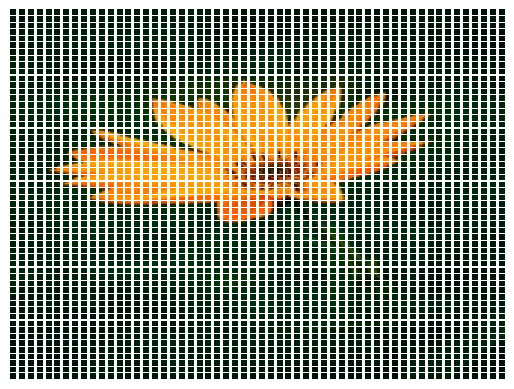

In [170]:
# tf part
n = int(np.sqrt(patches_tf.shape[1]))
print(n)
for i, patch in enumerate(patches_tf[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (4, 4, 3))
    ax.imshow(patch_img.numpy().astype("uint8"))
    ax.axis("off")

56


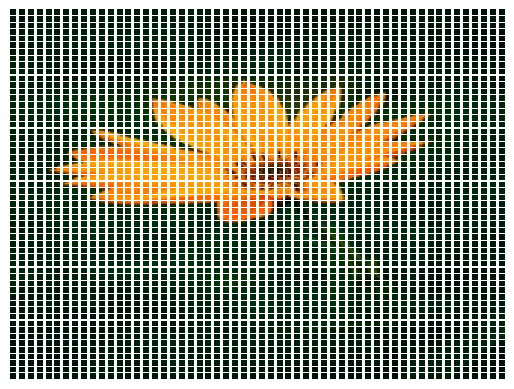

In [171]:
# torch part
n = int(np.sqrt(torch_patches.shape[1]))
# 1, 56*56, 48
print(n)
for i, patch in enumerate(torch_patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = patch.view(3, 4, 4)
    patch_img = patch_img.permute(1, 2, 0)
    ax.imshow(patch_img.numpy().astype("uint8"))
    ax.axis("off")